In [108]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Validation on Transaction Imputation and Pre-Post Treatment Consistency

### 1. Read in and Process Data

In [109]:
# Read in all nights booked
nights = pd.read_csv("boston_2019_nights_booked.csv")
nights['date'] = pd.to_datetime(nights.date)
nights = nights[(nights.date <= datetime(2019,12,31)) & (nights.date >= datetime(2019,1,1))]
nights['month'] = nights.date.dt.month
nights.head()

,id,name_prev,host_id_prev,host_name_prev,neighbourhood_group_prev,neighbourhood_prev,latitude_prev,longitude_prev,room_type_prev,number_of_reviews_prev,...,adjusted_price,minimum_nights,maximum_nights,adjusted_price_prev,minimum_nights_prev,maximum_nights_prev,adjusted_price_post,minimum_nights_post,maximum_nights_post,month
0,3781,HARBORSIDE-Walk to subway,4804,Frank,NaN,East Boston,42.365241,-71.029361,Entire home/apt,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,3781,HARBORSIDE-Walk to subway,4804,Frank,NaN,East Boston,42.365241,-71.029361,Entire home/apt,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,3781,HARBORSIDE-Walk to subway,4804,Frank,NaN,East Boston,42.365241,-71.029361,Entire home/apt,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,3781,HARBORSIDE-Walk to subway,4804,Frank,NaN,East Boston,42.365241,-71.029361,Entire home/apt,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,3781,HARBORSIDE-Walk to subway,4804,Frank,NaN,East Boston,42.365241,-71.029361,Entire home/apt,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [110]:
# Aggregate all reviews
all_reviews = pd.read_csv("boston_reviews/jan_2019_reviews.csv")
all_reviews["date"] = pd.to_datetime(all_reviews.date)
months = ["jan_2019", "feb_2019", "mar_2019", "apr_2019", "may_2019", "jun_2019", "jul_2019", "aug_2019", "sep_2019", "oct_2019", "nov_2019", "dec_2019", "jan_2020", "feb_2020"]
for m in months:
    path = "boston_reviews/"+m+"_reviews.csv"
    m_reviews = pd.read_csv(path)
    m_reviews["date"] = pd.to_datetime(m_reviews.date)
    all_reviews = all_reviews.merge(m_reviews, on = ["listing_id", "date"], how = "outer")
    all_reviews = all_reviews.groupby(["listing_id", "date"]).count().reset_index()
    all_reviews = all_reviews[all_reviews.date >= datetime(2019,1,1)]
all_reviews = all_reviews[all_reviews.date <= datetime(2019,12,31)]

# Since `nights` only contains listings with 100+ listings free per year
all_reviews = all_reviews[all_reviews.listing_id.isin(nights.id.unique())]
all_reviews['month'] = all_reviews.date.dt.month
all_reviews.head()

,listing_id,date,month
14,3781,2019-02-22,2
15,3781,2019-12-21,12
96,5506,2019-02-18,2
97,5506,2019-03-17,3
98,5506,2019-03-30,3


### 2. Match on Month Level

In [111]:
nights_by_month = nights.groupby('month').count().id

In [112]:
reviews_by_month = all_reviews.groupby('month').count().listing_id

In [113]:
by_month = pd.DataFrame({"reviews": reviews_by_month, "stays": nights_by_month}).reset_index()
first_half = by_month[by_month.month < 7]
second_half = by_month[by_month.month > 6]

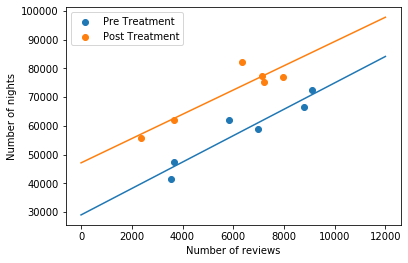

In [114]:
overall_coefs = np.polyfit(reviews_by_month, nights_by_month, 1)
first_half_coefs = np.polyfit(first_half.reviews, first_half.stays, 1)
second_half_coefs = np.polyfit(second_half.reviews, second_half.stays, 1)
x = np.arange(12000)
y_overall = x * overall_coefs[0] + overall_coefs[1]
y_first_half = x * first_half_coefs[0] + first_half_coefs[1]
y_second_half = x * second_half_coefs[0] + second_half_coefs[1]

plt.scatter(first_half.reviews, first_half.stays, label = "Pre Treatment")
plt.scatter(second_half.reviews, second_half.stays, label = "Post Treatment")
plt.plot(x, y_first_half)
plt.plot(x, y_second_half)
plt.xlabel("Number of reviews")
plt.ylabel("Number of nights")
plt.legend();

In [115]:
print("Overall coefficients:", overall_coefs)
print("Jan-Jun coefficients:", first_half_coefs)
print("Jul-Dec coefficients:", second_half_coefs)

Overall coefficients: [3.95485841e+00 4.08654220e+04]
Jan-Jun coefficients: [4.59607579e+00 2.89984396e+04]
Jul-Dec coefficients: [4.22337122e+00 4.71194980e+04]


In [116]:
np.corrcoef(first_half.reviews, first_half.stays)

array([[1.        , 0.94873921],
       [0.94873921, 1.        ]])

In [117]:
np.corrcoef(second_half.reviews, second_half.stays)

array([[1.        , 0.91415097],
       [0.91415097, 1.        ]])

### 3. Match on Unit

In [118]:
nights_by_unit_month = nights.groupby(['id', 'month']).count().reset_index()[['id', 'month', 'name_prev']].rename({'name_prev': 'nights'}, axis = 1)
nights_by_unit_month.head()

,id,month,nights
0,3781,1,31
1,3781,2,13
2,3781,3,31
3,3781,4,27
4,3781,5,27


In [119]:
reviews_by_unit_month = all_reviews.groupby(['listing_id', 'month']).count().reset_index().rename({'date': "reviews"}, axis = 1)
reviews_by_unit_month.head()

,listing_id,month,reviews
0,3781,2,1
1,3781,12,1
2,5506,2,1
3,5506,3,2
4,5506,4,2


In [120]:
data_by_unit_month = nights_by_unit_month.merge(reviews_by_unit_month, 
                                                left_on = ['id', 'month'], 
                                                right_on = ['listing_id', 'month'], 
                                                how = 'left')

data_by_unit_month = data_by_unit_month.drop("listing_id", axis = 1)
data_by_unit_month = data_by_unit_month.fillna(0)
data_by_unit_month['pre'] = (data_by_unit_month.month < 7).astype(int)

In [121]:
def has_both(df):
    if len(df.pre.unique()) > 1 and np.sum(df.nights) > 7:
        return True
    else:
        return False
in_pre_post = data_by_unit_month.groupby('id').apply(has_both).reset_index()
in_pre_post_ids = in_pre_post[in_pre_post[0] == True]['id']
data_by_unit_month = data_by_unit_month[data_by_unit_month.id.isin(in_pre_post_ids)]

In [122]:
data_by_unit_month = data_by_unit_month.groupby(['id', 'pre']).sum().reset_index()
pre = data_by_unit_month[data_by_unit_month.pre == 1]
post = data_by_unit_month[data_by_unit_month.pre == 0]

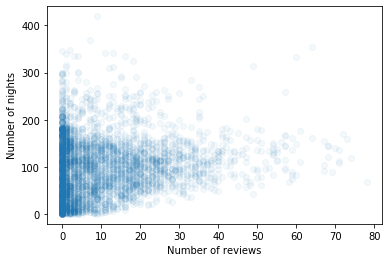

In [123]:
plt.scatter(pre.reviews, pre.nights, alpha = 0.05)
plt.xlabel("Number of reviews")
plt.ylabel("Number of nights");

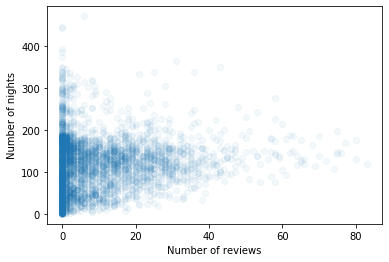

In [124]:
plt.scatter(post.reviews, post.nights, alpha = 0.05)
plt.xlabel("Number of reviews")
plt.ylabel("Number of nights");

In [125]:
np.corrcoef(pre.reviews, pre.nights, 1)

array([[1.        , 0.15900979],
       [0.15900979, 1.        ]])

In [126]:
np.corrcoef(post.reviews, post.nights, 1)

array([[1.        , 0.11339267],
       [0.11339267, 1.        ]])